<a href="https://colab.research.google.com/github/SSGrady/Rec-System/blob/main/Recommendation_System_StevenGrady.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  1782k      0 --:--:-- --:--:-- --:--:-- 1785k


##Movie Recommendation System: Collaborative Filtering + Kmeans + Matrix Factorization

In [2]:
import zipfile
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
  zip_ref.extractall('data')

In [3]:
import pandas as pd
#|-- import the dataset --|

# dimensions of movies are (9742, 3)
movies_df = pd.read_csv('data/ml-latest-small/movies.csv')
# dimensions of ratings are (100836, 4)
ratings_df = pd.read_csv('data/ml-latest-small/ratings.csv')

In [4]:
# View movies_df
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
#View ratings_df
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
# Mapping movie ID to movie name for each item
movies_names = movies_df.set_index('movieId')['title'].to_dict()

n_users = len(ratings_df.userId.unique())
m_items = len(ratings_df.movieId.unique())
matrix_nm = n_users * m_items

print("Number of unique users", n_users)
print("Number of unique items", m_items)
print("Full ratings matrix will contain", n_users*m_items, " elemnts")
print("Number of ratings is", ratings_df.shape[0])
print("So ",round(len(ratings_df)/matrix_nm*100, 2), "% of the matrix is full")
print("This means that we have an incredibly sparse dataset matrix")
print("To work with global scale, storing a full matrix in memory will be the challenge")
print("Matrix factorization can realize the rating matrix implicitly (don't need all data!)")

Number of unique users 610
Number of unique items 9724
Full ratings matrix will contain 5931640  elemnts
Number of ratings is 100836
So  1.7 % of the matrix is full
This means that we have an incredibly sparse dataset matrix
To work with global scale, storing a full matrix in memory will be the challenge
Matrix factorization can realize the rating matrix implicitly (don't need all data!)


In [26]:
import torch
import numpy as np
from torch.autograd import Variable
from tqdm.notebook import tqdm as tqdm

class MatrixFactorization(torch.nn.Module):
  def __init__(self, n_users, m_items, n_factors=20):
    super().__init__()
    #create user embeddings - i.e. look up table for the input
    self.user_factors = torch.nn.Embedding(n_users, n_factors)
    # create item embeddings - i.e. look up tables
    self.item_factors = torch.nn.Embedding(m_items, n_factors)

    # tuneable parameters
    self.user_factors.weight.data.uniform_(0, 0.05)
    self.item_factors.weight.data.uniform_(0, 0.05)

  def forward(self, data):
    # matrix multiplication
    users, items = data[:,0], data[:,1]
    return (self.user_factors(users)*self.item_factors(items)).sum(1)

  def predict(self, user, item):
    return self.forward(user, item)

In [22]:
# Creating the dataloader for PyTorch - helps transform data to ML readiness
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# An efficient and convenient way to manage/process data for training
class Loader(Dataset):
  def __init__(self):
      # not recommended but is possible since ratings_df is stored in memory
      self.ratings = ratings_df.copy()
      # Extract all user IDs and movie IDs
      users = ratings_df.userId.unique()
      movies = ratings_df.movieId.unique()

      #--- Producing new continuous IDs for users and movies ---

      # Unique values : index
      self.userid2idx = {o:i for i,o in enumerate(users)}
      self.movieid2idx = {o:i for i,o in enumerate(movies)}

      # Obtained continuous ID for users and movies
      self.idx2userid = {i:o for o,i in self.userid2idx.items()}
      self.idx2movieid = {i:o for o,i in self.movieid2idx.items()}

      # return the id from the indexed values as noted in the lambda function down below.
      self.ratings.movieId = ratings_df.movieId.apply(lambda x: self.movieid2idx[x])
      self.ratings.userId = ratings_df.userId.apply(lambda x: self.userid2idx[x])


      self.x = self.ratings.drop(['rating', 'timestamp'], axis=1).values
      self.y = self.ratings['rating'].values
      self.x, self.y = torch.tensor(self.x), torch.tensor(self.y) # Transforms the data to tensors (ready for torch models.)

  # returns number of smaples in the dataset
  def __len__(self):
    return len(self.ratings)
  # returns a specified sample at the given index
  def __getitem__(self, index):
    return self.x[index], self.y[index]

In [47]:
num_epochs = 50
cuda = torch.cuda.is_available()

print("Is running on GPU: ", cuda)

model = MatrixFactorization(n_users, m_items, n_factors=12)
print("\n", model)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

if cuda:
    model = model.cuda()

# MSE loss
loss_fn = torch.nn.MSELoss()

# ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train data
train_set = Loader()
train_loader = DataLoader(train_set, 50, shuffle=True)

Is running on GPU:  False

 MatrixFactorization(
  (user_factors): Embedding(610, 12)
  (item_factors): Embedding(9724, 12)
)
user_factors.weight tensor([[0.0196, 0.0411, 0.0121,  ..., 0.0035, 0.0075, 0.0199],
        [0.0471, 0.0207, 0.0426,  ..., 0.0405, 0.0142, 0.0037],
        [0.0172, 0.0424, 0.0307,  ..., 0.0342, 0.0484, 0.0402],
        ...,
        [0.0108, 0.0295, 0.0076,  ..., 0.0190, 0.0083, 0.0172],
        [0.0370, 0.0277, 0.0069,  ..., 0.0180, 0.0267, 0.0488],
        [0.0092, 0.0120, 0.0144,  ..., 0.0493, 0.0184, 0.0180]])
item_factors.weight tensor([[0.0334, 0.0336, 0.0431,  ..., 0.0352, 0.0056, 0.0187],
        [0.0053, 0.0355, 0.0092,  ..., 0.0474, 0.0474, 0.0166],
        [0.0115, 0.0281, 0.0474,  ..., 0.0425, 0.0402, 0.0051],
        ...,
        [0.0180, 0.0272, 0.0484,  ..., 0.0008, 0.0246, 0.0395],
        [0.0367, 0.0198, 0.0191,  ..., 0.0260, 0.0234, 0.0467],
        [0.0204, 0.0262, 0.0204,  ..., 0.0280, 0.0224, 0.0044]])


In [48]:
epoch_losses = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    losses = []
    for x, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    epoch_loss = sum(losses) / len(losses)
    epoch_losses.append(epoch_loss)
    print("Epoch #{}".format(epoch), "Loss:", epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch #0 Loss: 8.03016169034554
Epoch #1 Loss: 2.3546444478162636
Epoch #2 Loss: 1.3968878136924665
Epoch #3 Loss: 1.0630294004169856
Epoch #4 Loss: 0.9100246157720648
Epoch #5 Loss: 0.8284236307361661
Epoch #6 Loss: 0.7788494034131447
Epoch #7 Loss: 0.7471671661322342
Epoch #8 Loss: 0.7248025101396668
Epoch #9 Loss: 0.7093973175599898
Epoch #10 Loss: 0.6990687768088157
Epoch #11 Loss: 0.6917824992669
Epoch #12 Loss: 0.6870583438997406
Epoch #13 Loss: 0.683972324645927
Epoch #14 Loss: 0.6803968815325981
Epoch #15 Loss: 0.6790680826508178
Epoch #16 Loss: 0.6748153266483566
Epoch #17 Loss: 0.6705498618245066
Epoch #18 Loss: 0.6655160770389072
Epoch #19 Loss: 0.6574675620163675
Epoch #20 Loss: 0.6464247968699829
Epoch #21 Loss: 0.6327081333012881
Epoch #22 Loss: 0.6154695504673294
Epoch #23 Loss: 0.5949136795578585
Epoch #24 Loss: 0.5732574728481475
Epoch #25 Loss: 0.5503018360416903
Epoch #26 Loss: 0.5273656377889286
Epoch #27 Loss: 0.5058177974579295
Epoch #28 Loss: 0.4853963046290819
E

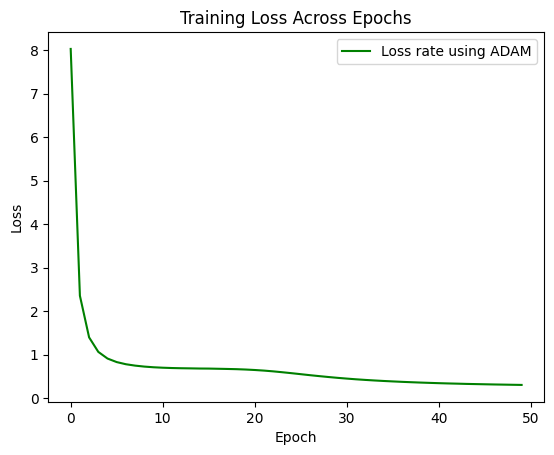

In [53]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), epoch_losses, label='Loss rate using ADAM', c='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Across Epochs')
plt.legend()
plt.show()
plt.close()